# Pos Cash Balance Dataset Analysis

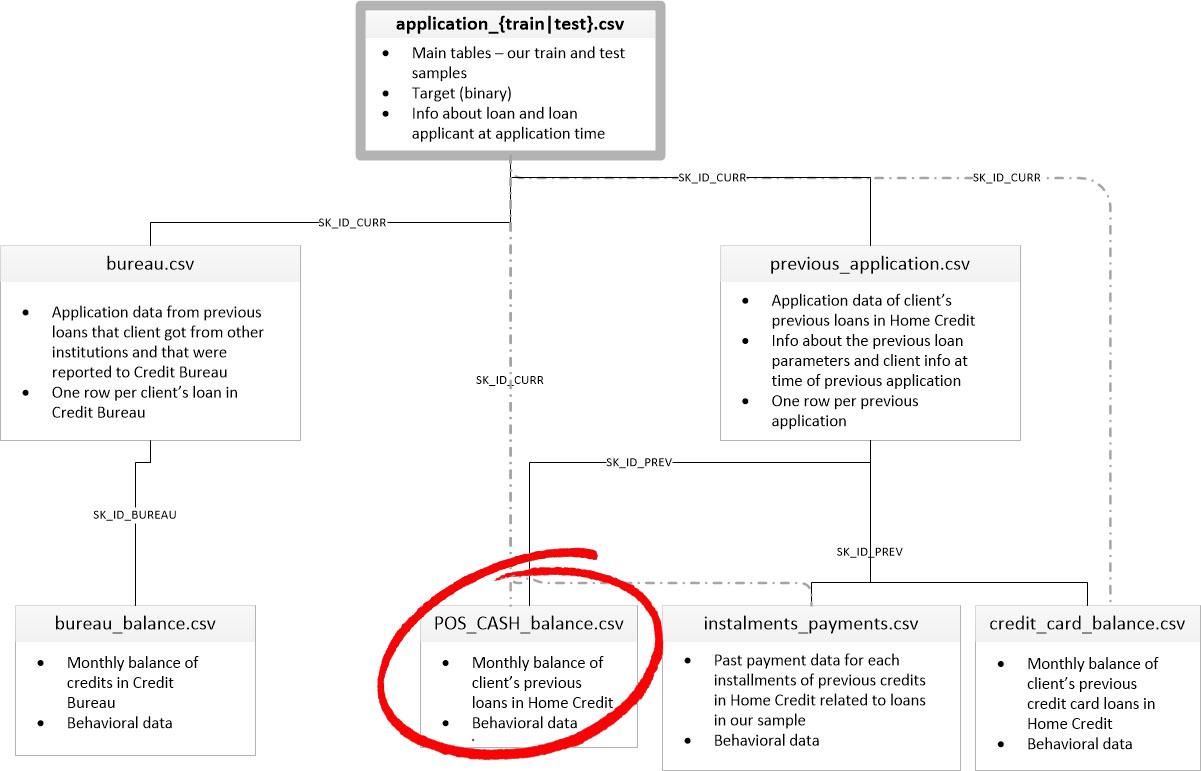

In this notebook I will try to explore POS_CASH_balance dataset and see what we can take from it.

Here is a short description from home credit about this dataset:
*  "Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit."

*  "This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows."

# Import Libraries

In [1]:
%load_ext nb_black
import homecredit_functions as hc
import imp

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", color_codes=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

RANDOM_STATE = 0

<IPython.core.display.Javascript object>

# Load Processed Application Datasets

### Application Test Processed Dataset

In [2]:
path_application_test_proc = "data/application_test_proc.csv"
df_application_test_proc = pd.read_csv(path_application_test_proc)

<IPython.core.display.Javascript object>

In [3]:
df_application_test_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,EXT_SOURCE_MIN,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,SK_ID_CURR
0,0.00000,0.00093,0.13079,0.25700,0.33754,0.04067,0.79045,0.88718,1.00000,1.00000,...,0.18150,0.13697,0.40086,0.11915,0.14272,0.03929,0.09607,0.99961,0.95603,100001
1,0.00000,0.00063,0.04439,0.49159,0.40389,0.03509,0.63043,0.77449,1.00000,1.00000,...,0.33184,0.43293,0.12210,0.25106,0.05407,0.02141,0.09867,0.99981,0.96073,100005
2,0.00000,0.00151,0.15437,0.26048,0.29262,0.03511,0.91184,0.51327,1.00000,1.00000,...,0.69517,0.62560,0.05975,0.03404,0.04381,0.03667,0.12049,0.99933,0.84987,100013
3,0.10526,0.00247,0.38202,0.36143,0.63433,0.04188,0.91894,0.41531,1.00000,1.00000,...,0.57990,0.10142,0.48475,0.05532,0.22152,0.05896,0.12821,0.99889,0.84877,100028
4,0.05263,0.00132,0.14494,0.13490,0.68709,0.04103,0.83787,0.40781,1.00000,1.00000,...,0.23000,0.24395,0.24761,0.23404,0.12441,0.04097,0.12821,0.99937,0.89487,100038


<IPython.core.display.Javascript object>

### Application Train Processed Dataset

In [4]:
path_application_train_proc = "data/application_train_proc.csv"
df_application_train_proc = pd.read_csv(path_application_train_proc)

<IPython.core.display.Javascript object>

In [5]:
df_application_train_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.31105,0.19041,0.54468,0.08367,0.02041,0.10717,0.99838,0.88820,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.07648,0.56183,0.08511,0.21774,0.04932,0.10870,0.99874,0.90937,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.23499,0.25688,0.05532,0.12821,0.02356,0.12821,0.99874,0.98744,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.55299,0.07905,0.06809,0.05132,0.02592,0.12049,0.99957,0.93432,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.18279,0.32191,0.15319,0.15483,0.04978,0.12821,0.99968,0.95478,0,100007


<IPython.core.display.Javascript object>

# EDA

### Posh Cash Balance Dataset

In [6]:
path_pos_cash = "data/POS_CASH_balance.csv"
df_pos_cash = pd.read_csv(path_pos_cash)

<IPython.core.display.Javascript object>

In [7]:
df_pos_cash.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00000,45.00000,Active,0,0
1,1715348,367990,-33,36.00000,35.00000,Active,0,0
2,1784872,397406,-32,12.00000,9.00000,Active,0,0
3,1903291,269225,-35,48.00000,42.00000,Active,0,0
4,2341044,334279,-35,36.00000,35.00000,Active,0,0


<IPython.core.display.Javascript object>

In [8]:
df_pos_cash.select_dtypes(["float64", "int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.00000,1903216.59896,535846.53072,1000001.00000,1434405.00000,1896565.00000,2368963.00000,2843499.00000
SK_ID_CURR,10001358.00000,278403.86331,102763.74509,100001.00000,189550.00000,278654.00000,367429.00000,456255.00000
MONTHS_BALANCE,10001358.00000,-35.01259,26.06657,-96.00000,-54.00000,-28.00000,-13.00000,-1.00000
CNT_INSTALMENT,9975287.00000,17.08965,11.99506,1.00000,10.00000,12.00000,24.00000,92.00000
CNT_INSTALMENT_FUTURE,9975271.00000,10.48384,11.10906,0.00000,3.00000,7.00000,14.00000,85.00000
SK_DPD,10001358.00000,11.60693,132.71404,0.00000,0.00000,0.00000,0.00000,4231.00000
SK_DPD_DEF,10001358.00000,0.65447,32.76249,0.00000,0.00000,0.00000,0.00000,3595.00000


<IPython.core.display.Javascript object>

In [9]:
df_pos_cash.select_dtypes(["object"]).describe().T

,count,unique,top,freq
NAME_CONTRACT_STATUS,10001358,9,Active,9151119


<IPython.core.display.Javascript object>

**Observation:**:
* Dataset has mixed types of features although most features are numerical and one is categorical.
* SK_DPD and SK_DPD_DEF features seems to have outliers, because their max values are significantly bigger than their mean values.

In [10]:
# Merge POS_CASH_balance dataset with application train dataset
df_pos_cash_analysis = df_pos_cash.copy()
df_pos_cash_analysis = df_pos_cash_analysis.merge(
    df_application_train_proc[["SK_ID_CURR", "TARGET"]], how="left", on="SK_ID_CURR"
)
df_pos_cash_analysis.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TARGET
0,1803195,182943,-31,48.00000,45.00000,Active,0,0,0.00000
1,1715348,367990,-33,36.00000,35.00000,Active,0,0,0.00000
2,1784872,397406,-32,12.00000,9.00000,Active,0,0,0.00000
3,1903291,269225,-35,48.00000,42.00000,Active,0,0,0.00000
4,2341044,334279,-35,36.00000,35.00000,Active,0,0,0.00000


<IPython.core.display.Javascript object>

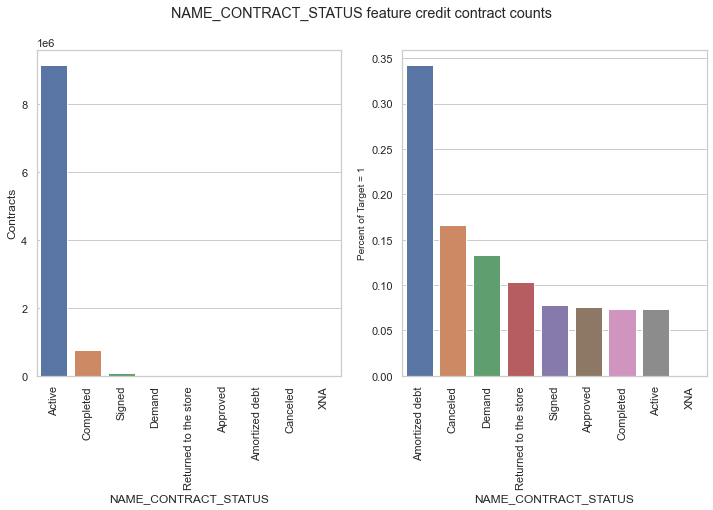

<IPython.core.display.Javascript object>

In [11]:
hc.plot_count(df_pos_cash_analysis, "NAME_CONTRACT_STATUS", True)

**Observation:**
* Most people have their contract status active, although clients with amortized debt have largest percents of defaults almost 0.35 procent.

# Data Wrangling

## Correlation

### Correlation with target

In [12]:
corrs_pos_cash = df_pos_cash_analysis.corr()[["TARGET"]].sort_values(
    by="TARGET", ascending=False
)
corrs_pos_cash = corrs_pos_cash.rename(columns={"TARGET": "target_corr"})
corrs_pos_cash = corrs_pos_cash.drop(["TARGET", "SK_ID_CURR"])
corrs_pos_cash

,target_corr
CNT_INSTALMENT_FUTURE,0.02197
MONTHS_BALANCE,0.02015
CNT_INSTALMENT,0.01851
SK_DPD,0.00987
SK_DPD_DEF,0.00859
SK_ID_PREV,-0.00006


<IPython.core.display.Javascript object>

As we can see there is not a lot of correlation going between our numerical features and target. 

# Pos Cash Balance Split Train/Test

In [13]:
%%time
df_pos_cash_agg  = hc.aggregate_samples(df_pos_cash.drop(columns=["SK_ID_PREV"]),"POS_")

Wall time: 26.7 s


<IPython.core.display.Javascript object>

In [14]:
df_pos_cash_agg.head(5)

,SK_ID_CURR,POS_MONTHS_BALANCE_MEAN,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MEAN,POS_MONTHS_BALANCE_MAX,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_FUTURE_MAX,POS_SK_DPD_MAX,...,POS_SK_DPD_SUM,POS_SK_DPD_DEF_SUM,POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN
0,100001,-72.55556,4.00000,1.44444,0.77778,0.77778,-53,4.00000,4.00000,7,...,7,7,0.00000,0.00000,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000
1,100002,-10.00000,24.00000,15.00000,0.00000,0.00000,-1,24.00000,24.00000,0,...,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100003,-43.78571,10.10714,5.78571,0.00000,0.00000,-18,12.00000,12.00000,0,...,0,0,0.00000,0.00000,0.00000,0.07143,0.00000,0.00000,0.00000,0.00000
3,100004,-25.50000,3.75000,2.25000,0.00000,0.00000,-24,4.00000,4.00000,0,...,0,0,0.00000,0.00000,0.00000,0.25000,0.00000,0.00000,0.00000,0.00000
4,100005,-20.00000,11.70000,7.20000,0.00000,0.00000,-15,12.00000,12.00000,0,...,0,0,0.00000,0.00000,0.00000,0.09091,0.00000,0.00000,0.09091,0.00000


<IPython.core.display.Javascript object>

In [15]:
%%time
# Splitting into train/test sets
df_train_sliced = df_application_train_proc[["SK_ID_CURR", "TARGET"]]
df_test_sliced = df_application_test_proc[["SK_ID_CURR"]]

df_pos_cash_train = df_train_sliced.merge(df_pos_cash_agg,how='left', on='SK_ID_CURR')
df_pos_cash_test = df_test_sliced.merge(df_pos_cash_agg,how='left', on='SK_ID_CURR')

Wall time: 878 ms


<IPython.core.display.Javascript object>

## Missing Values

In [16]:
missing_values_train = hc.missing_values(df_pos_cash_train)
missing_values_train

,Missing Values,% of Total Values
POS_CNT_INSTALMENT_FUTURE_MEAN,18091,5.90000
POS_CNT_INSTALMENT_MEAN,18091,5.90000
POS_CNT_INSTALMENT_MAX,18091,5.90000
POS_CNT_INSTALMENT_FUTURE_MAX,18091,5.90000
POS_CNT_INSTALMENT_FUTURE_MIN,18091,5.90000
POS_CNT_INSTALMENT_MIN,18091,5.90000
POS_MONTHS_BALANCE_MEAN,18067,5.90000
POS_NAME_CONTRACT_STATUS_Approved_MEAN,18067,5.90000
POS_SK_DPD_DEF_SUM,18067,5.90000
POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,18067,5.90000


<IPython.core.display.Javascript object>

### Impute Missing Values

In [17]:
%%time
df_pos_cash_train_imp, df_pos_cash_test_imp = hc.impute_missing_num(
    df_pos_cash_train,df_pos_cash_test, df_pos_cash_test.columns
)

Wall time: 1.81 s


<IPython.core.display.Javascript object>

In [19]:
hc.missing_values(df_pos_cash_train_imp).head(5)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

In [20]:
hc.missing_values(df_pos_cash_test_imp).head(5)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

# Scale

In [21]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_pos_cash_train_imp,
    df_pos_cash_test_imp,
)

<IPython.core.display.Javascript object>

In [22]:
df_train_full_scaled.head(5)

,POS_MONTHS_BALANCE_MEAN,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MEAN,POS_MONTHS_BALANCE_MAX,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_FUTURE_MAX,POS_SK_DPD_MAX,POS_SK_DPD_DEF_MAX,...,POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,TARGET,SK_ID_CURR
0,0.90526,0.32394,0.25000,0.00000,0.00000,1.00000,0.27711,0.28571,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,100002.00000
1,0.54962,0.12827,0.09643,0.00000,0.00000,0.82105,0.13253,0.14286,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.07143,0.00000,0.00000,0.00000,0.00000,0,100003.00000
2,0.74211,0.03873,0.03750,0.00000,0.00000,0.75789,0.03614,0.04762,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.25000,0.00000,0.00000,0.00000,0.00000,0,100004.00000
3,0.90927,0.15493,0.14417,0.00000,0.00000,1.00000,0.56627,0.57143,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.09524,0.00000,0.04762,0.00000,0.00000,0,100006.00000
4,0.65646,0.20188,0.14949,0.00000,0.00000,1.00000,0.27711,0.28571,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.01515,0.00000,0,100007.00000


<IPython.core.display.Javascript object>

# Baseline model

In [23]:
X_train_full = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

y_train_full = df_train_full_scaled["TARGET"]

<IPython.core.display.Javascript object>

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_full,
)

<IPython.core.display.Javascript object>

### LGBM

In [25]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [26]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 3.2 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [27]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.6068827030015284
Validation accuracy is 0.5916134172316797
Training precision is 0.12277394906834738
Validation precision is 0.1038996776476138
Training recall is 0.6297079556898288
Validation recall is 0.5323262839879154
Training ROC AUC is 0.6715041477930636
Validation ROC AUC is 0.5953900836934989


<IPython.core.display.Javascript object>

In [28]:
df_scores = pd.DataFrame()

dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Baseline With All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))

df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.60688,0.59161,0.12277,0.10390,0.62971,0.53233,0.67150,0.59539


<IPython.core.display.Javascript object>

In [29]:
hc.get_importance(LGBM_clsf, X_train_full, 20)

,Feature,Weight
0,POS_MONTHS_BALANCE_MEAN,276
23,POS_NAME_CONTRACT_STATUS_Completed_MEAN,268
15,POS_MONTHS_BALANCE_SUM,243
1,POS_CNT_INSTALMENT_MEAN,243
2,POS_CNT_INSTALMENT_FUTURE_MEAN,235
17,POS_CNT_INSTALMENT_FUTURE_SUM,210
5,POS_MONTHS_BALANCE_MAX,205
10,POS_MONTHS_BALANCE_MIN,183
16,POS_CNT_INSTALMENT_SUM,181
11,POS_CNT_INSTALMENT_MIN,142


<IPython.core.display.Javascript object>

# Outliers

In [30]:
num_columns = []
for column in df_pos_cash.drop(
    columns=["SK_ID_PREV", "SK_ID_CURR", "NAME_CONTRACT_STATUS"]
).columns:
    num_columns.append("POS_" + column + "_MEAN")
    num_columns.append("POS_" + column + "_MAX")
    num_columns.append("POS_" + column + "_MIN")

<IPython.core.display.Javascript object>

In [44]:
%%time
result = pd.DataFrame()
for feature in num_columns:    
    stats = hc.isolation_forest_feature(df_pos_cash_train_imp, feature)
    result = pd.concat([result, stats])

Wall time: 7min 39s


<IPython.core.display.Javascript object>

In [45]:
outliers = {
    team: grp.drop("feature", axis=1)
    for team, grp in result.sort_values(by="score").groupby("feature")
}

<IPython.core.display.Javascript object>

In [46]:
n_outliers = 20
for feature in num_columns:
    print_outliers(outliers, feature, n_outliers)

POS_MONTHS_BALANCE_MEAN
             val    score  outlier       min      max      mean
197330 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
58608  -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
89539  -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
123549 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
190548 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
147103 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
141094 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
195978 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
227806 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
145632 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
221868 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
189703 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
151252 -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
87697  -96.00000 -0.10115       -1 -96.00000 -1.00000 -31.64133
72132  -96.00000

<IPython.core.display.Javascript object>

In [47]:
len(df_pos_cash_train[df_pos_cash_train["POS_SK_DPD_MEAN"] > 100])

2125

<IPython.core.display.Javascript object>

In [48]:
len(df_pos_cash_train[df_pos_cash_train["POS_SK_DPD_DEF_MEAN"] > 100])

44

<IPython.core.display.Javascript object>

In [49]:
len(df_pos_cash_train[df_pos_cash_train["POS_CNT_INSTALMENT_MIN"] >= 50])

275

<IPython.core.display.Javascript object>

As we noticed before POS_SK_DPD and POS_SK_DPD_DEF features has most extreme max values comparing to mean values. Moreover seems that POS_CNT_INSTALMENT_MIN feature has high isolation forest scores as well. Let's clip these values and see if that can effect our LGBM score.

In [33]:
df_pos_cash_train_iso = df_pos_cash_train_imp.copy()
df_pos_cash_test_iso = df_pos_cash_test_imp.copy()

for feature in [
    "POS_SK_DPD_MEAN",
    "POS_SK_DPD_MAX",
    "POS_SK_DPD_MIN",
    "POS_SK_DPD_DEF_MEAN",
    "POS_SK_DPD_DEF_MAX",
    "POS_SK_DPD_DEF_MIN",
]:
    df_pos_cash_train_iso[feature] = df_pos_cash_train[feature].clip(0, 100)
    df_pos_cash_test_iso[feature] = df_pos_cash_test[feature].clip(0, 100)

df_pos_cash_train_iso["POS_CNT_INSTALMENT_MIN"] = df_pos_cash_train[
    "POS_CNT_INSTALMENT_MIN"
].clip(0, 50)
df_pos_cash_test_iso["POS_CNT_INSTALMENT_MIN"] = df_pos_cash_test[
    "POS_CNT_INSTALMENT_MIN"
].clip(0, 50)

<IPython.core.display.Javascript object>

In [34]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_pos_cash_train_iso, df_pos_cash_test_iso
)

<IPython.core.display.Javascript object>

In [36]:
X_train_full_iso = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full_iso = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [37]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_iso,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [40]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [41]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 2.83 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [42]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.602228382816819
Validation accuracy is 0.5886542119896591
Training precision is 0.1224209211583707
Validation precision is 0.10482742537313433
Training recall is 0.6366565961732125
Validation recall is 0.543202416918429
Training ROC AUC is 0.6717142706197037
Validation ROC AUC is 0.5976103836551998


<IPython.core.display.Javascript object>

In [43]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Outliers Clipping"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.60688,0.59161,0.12277,0.10390,0.62971,0.53233,0.67150,0.59539
1,LGBM,Outliers Clipping,0.60223,0.58865,0.12242,0.10483,0.63666,0.54320,0.67171,0.59761


<IPython.core.display.Javascript object>

As we can see clipping outliers helped to increase ROC_AUC scores although on kaggle it actually decreased scores a tiny bit. Therefore I left these outliers in.

# Saving Final DataFrames

In [44]:
df_scores.to_csv("data/POS_CASH_balance_scores.csv", index=False)

<IPython.core.display.Javascript object>

In [29]:
df_train_full_scaled.drop(columns=["TARGET"]).to_csv(
    "data/POS_CASH_balance_train_proc.csv", index=False
)
df_test_full_scaled.to_csv("data/POS_CASH_balance_test_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [30]:
pd.read_csv("data/POS_CASH_balance_train_proc.csv")

,PREV_MONTHS_BALANCE_MEAN,PREV_CNT_INSTALMENT_MEAN,PREV_CNT_INSTALMENT_FUTURE_MEAN,PREV_SK_DPD_MEAN,PREV_SK_DPD_DEF_MEAN,PREV_MONTHS_BALANCE_MAX,PREV_CNT_INSTALMENT_MAX,PREV_CNT_INSTALMENT_FUTURE_MAX,PREV_SK_DPD_MAX,PREV_SK_DPD_DEF_MAX,...,PREV_SK_DPD_DEF_SUM,PREV_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Completed_MEAN,PREV_NAME_CONTRACT_STATUS_Demand_MEAN,PREV_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,PREV_NAME_CONTRACT_STATUS_Signed_MEAN,PREV_NAME_CONTRACT_STATUS_XNA_MEAN,SK_ID_CURR
0,0.90526,0.32394,0.25000,0.00000,0.00000,1.00000,0.27711,0.28571,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100002.00000
1,0.54962,0.12827,0.09643,0.00000,0.00000,0.82105,0.13253,0.14286,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.07143,0.00000,0.00000,0.00000,0.00000,100003.00000
2,0.74211,0.03873,0.03750,0.00000,0.00000,0.75789,0.03614,0.04762,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.25000,0.00000,0.00000,0.00000,0.00000,100004.00000
3,0.90927,0.15493,0.14417,0.00000,0.00000,1.00000,0.56627,0.57143,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.09524,0.00000,0.04762,0.00000,0.00000,100006.00000
4,0.65646,0.20188,0.14949,0.00000,0.00000,1.00000,0.27711,0.28571,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000,0.01515,0.00000,100007.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.95789,0.09683,0.07292,0.00000,0.00000,1.00000,0.08434,0.09524,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.11111,0.00000,0.00000,0.11111,0.00000,456251.00000
307507,0.17895,0.07042,0.05000,0.00000,0.00000,0.21053,0.06024,0.07143,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.14286,0.00000,0.00000,0.00000,0.00000,456252.00000
307508,0.17647,0.08036,0.03333,0.00011,0.00017,0.41053,0.13253,0.07143,0.00118,0.00148,...,0.00003,0.00000,0.00000,0.00000,0.11765,0.00000,0.00000,0.00000,0.00000,456253.00000
307509,0.95211,0.19577,0.17250,0.00000,0.00000,1.00000,0.18072,0.19048,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456254.00000


<IPython.core.display.Javascript object>